# **Project: image classification with feature extraction scikit_learn**

### **Imports and Installation**

In [1]:
# Install required libraries
!pip install img2vec_pytorch kagglehub -q

import os
import shutil
import random
import joblib
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import kagglehub

from PIL import Image
from img2vec_pytorch import Img2Vec
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from tqdm.notebook import tqdm

print("Libraries installed and imported successfully.")

Libraries installed and imported successfully.


### **Data Download, Preparation, and Visualization**

Using Colab cache for faster access to the 'garbage-classification' dataset.
Path to dataset files: /kaggle/input/garbage-classification
Reorganizing data into Train/Val folders...


  0%|          | 0/6 [00:00<?, ?it/s]


--- Data Visualization ---


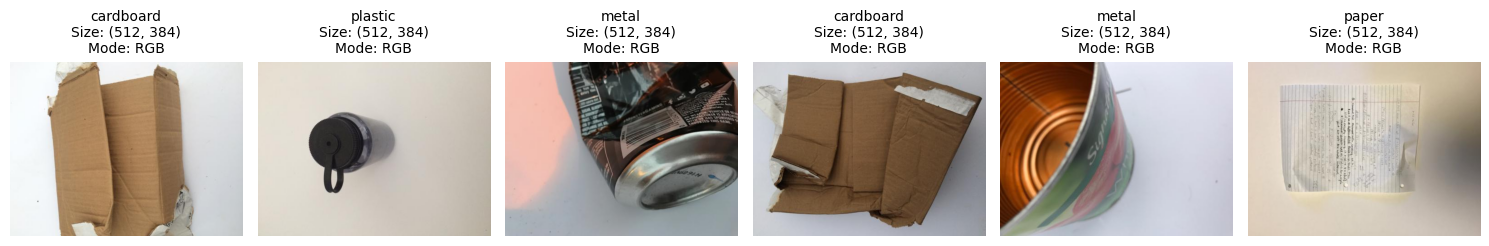

In [ ]:
# 1. Download dataset
print("Downloading dataset...")
path = kagglehub.dataset_download("asdasdasasdas/garbage-classification")
print("Path to dataset files:", path)

# 2. Setup paths for split structure
base_dir = './data/garbage_dataset'
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')

if os.path.exists(base_dir):
    shutil.rmtree(base_dir) # rmtree mean remove directory and all its contents

# 3. Automatic Split Script (80% Train / 20% Val)
print("Reorganizing data into Train/Val folders...")
source_path = os.path.join(path, "Garbage classification", "Garbage classification")

# Fallback if structure differs
if not os.path.exists(source_path):
    source_path = path

categories = [d for d in os.listdir(source_path) if os.path.isdir(os.path.join(source_path, d))]

for category in tqdm(categories):
    os.makedirs(os.path.join(train_dir, category), exist_ok=True)
    os.makedirs(os.path.join(val_dir, category), exist_ok=True)

    cat_source = os.path.join(source_path, category)
    images = os.listdir(cat_source)
    random.shuffle(images)

    split_idx = int(len(images) * 0.8)
    train_imgs = images[:split_idx]
    val_imgs = images[split_idx:]

    for img in train_imgs:
        shutil.copy(os.path.join(cat_source, img), os.path.join(train_dir, category, img))
    for img in val_imgs:
        shutil.copy(os.path.join(cat_source, img), os.path.join(val_dir, category, img))

# 4. Visualization of Data
print("\n--- Data Visualization ---")
def visualize_samples(directory, num_samples=6):
    categories = os.listdir(directory)
    fig, axes = plt.subplots(1, num_samples, figsize=(15, 5))

    for i in range(num_samples):
        # Pick random category and image
        cat = random.choice(categories)
        img_name = random.choice(os.listdir(os.path.join(directory, cat)))
        img_path = os.path.join(directory, cat, img_name)

        img = Image.open(img_path)

        # Display
        axes[i].imshow(img)
        axes[i].axis('off')
        # Show Metadata: Category, Dimensions (Width x Height), Mode (RGB/RGBA)
        axes[i].set_title(f"{cat}\nSize: {img.size}\nMode: {img.mode}", fontsize=10)

    plt.tight_layout()
    plt.show()

visualize_samples(train_dir)

### **Feature Extraction and Model Training**

## **feature extraction loop**

This line of code is a smart way to create a loop that gives you **two things at once**: a counter (0, 1, 2...) and the item itself.

Here is the breakdown of `for j, dir_ in enumerate([train_dir, val_dir]):`

### 1. The Components

* **`[train_dir, val_dir]`**: This is a list of two items.
* **`enumerate(...)`**: This function takes that list and attaches a number to each item, starting from 0.
* It turns `train_dir` into  `(0, train_dir)`
* It turns `val_dir` into  `(1, val_dir)`


* **`j, dir_`**: These are variables that "unpack" that pair.
* **`j`** gets the number (0 or 1).
* **`dir_`** gets the folder path.



### 2. What happens inside the loop?

**Round 1 (The Training Data):**

* `j` = **0**
* `dir_` = **`train_dir`**
* *Why this matters:* In your code, you use `j` (which is 0) to grab the string `'training_data'` from your list of keys.

**Round 2 (The Validation Data):**

* `j` = **1**
* `dir_` = **`val_dir`**
* *Why this matters:* Now `j` is 1, so the code grabs the second key `'validation_data'` to store the next batch of features.

### In Plain English

"Loop through this list of folders. Call the **first folder** `dir_` and label it **#0** (j). Then call the **second folder** `dir_` and label it **#1** (j)."

In [ ]:
# Initialize Img2Vec (uses ResNet-18 by default)
img2vec = Img2Vec()

data = {}
print("Extracting features from images...")

for j, dir_ in enumerate([train_dir, val_dir]):
    features = []
    labels = []

    for category in os.listdir(dir_):
        cat_path = os.path.join(dir_, category)
        if not os.path.isdir(cat_path): continue

        for img_file in os.listdir(cat_path):
            img_path = os.path.join(cat_path, img_file)

            try:
                # Convert to RGB to ensure consistency (handles PNGs with transparency)
                img = Image.open(img_path).convert('RGB')

                # Get vector (512 dimensions)
                img_features = img2vec.get_vec(img, tensor=True)

                features.append(img_features.flatten())
                labels.append(category)
            except Exception as e:
                print(f"Error processing {img_path}: {e}")

    # Store in dictionary key based on iteration (0=train, 1=val)
    data[['training_data', 'validation_data'][j]] = features
    data[['training_labels', 'validation_labels'][j]] = labels

print("Feature extraction finished.")

# Train Random Forest
print("Training Random Forest Classifier...")
model = RandomForestClassifier(random_state=42, n_estimators=100) # random_state for reproducibility , n_estimators is number of trees in the forest
model.fit(data['training_data'], data['training_labels'])
print("Training complete.")

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 66.7MB/s]


Extracting features from images...
Feature extraction finished.
Training Random Forest Classifier...
Training complete.


### **Evaluation and Saving**

Model Accuracy: 81.30%

--- Classification Report ---
              precision    recall  f1-score   support

   cardboard       0.95      0.88      0.91        81
       glass       0.80      0.83      0.82       101
       metal       0.76      0.82      0.79        82
       paper       0.78      0.97      0.86       119
     plastic       0.82      0.75      0.78        97
       trash       1.00      0.11      0.19        28

    accuracy                           0.81       508
   macro avg       0.85      0.73      0.73       508
weighted avg       0.83      0.81      0.80       508



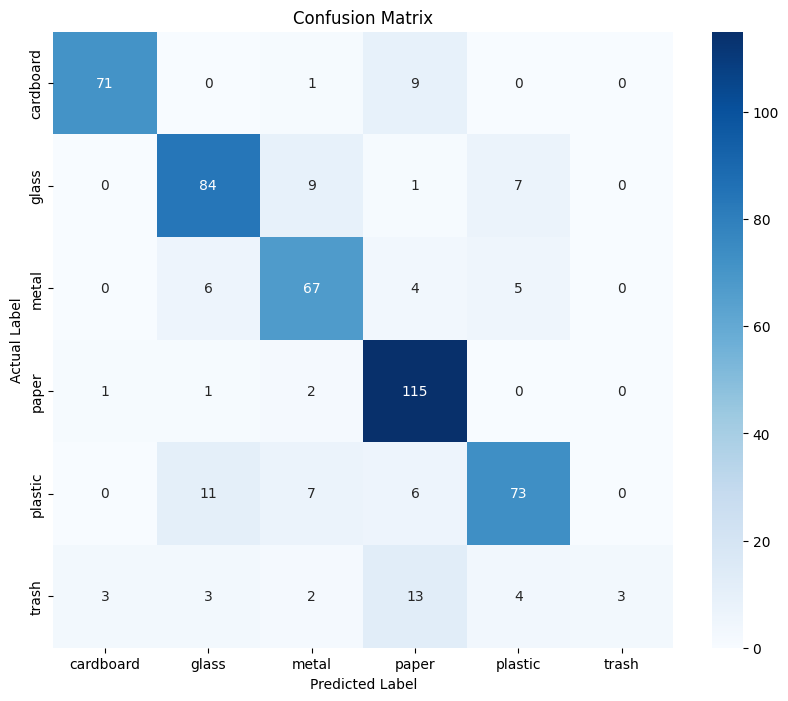

Model saved as garbage_classifier.joblib


In [5]:
# Predict on validation data
y_pred = model.predict(data['validation_data'])

# Calculate Accuracy
acc = accuracy_score(data['validation_labels'], y_pred)
print(f"Model Accuracy: {acc*100:.2f}%")

# Detailed Classification Report
print("\n--- Classification Report ---")
print(classification_report(data['validation_labels'], y_pred))

# Confusion Matrix Visualization
plt.figure(figsize=(10, 8))
cm = confusion_matrix(data['validation_labels'], y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=sorted(set(data['validation_labels'])),
            yticklabels=sorted(set(data['validation_labels'])))
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.title('Confusion Matrix')
plt.show()

# Save Model using Joblib
model_filename = 'garbage_classifier.joblib'
joblib.dump(model, model_filename)
print(f"Model saved as {model_filename}")

### **Inference (Testing the Model)**

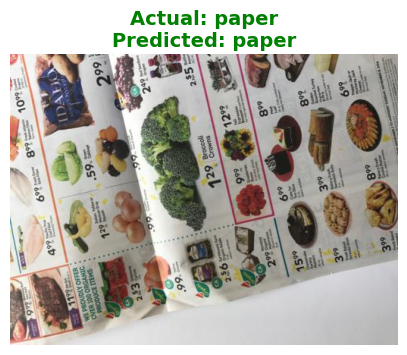

Input Image Path: ./data/garbage_dataset/val/paper/paper227.jpg
Model Prediction: paper


In [6]:
# Load the model
loaded_model = joblib.load('garbage_classifier.joblib')
img2vec = Img2Vec()

# Select a random test image
test_cat = random.choice(os.listdir(val_dir))
test_img_name = random.choice(os.listdir(os.path.join(val_dir, test_cat)))
image_path = os.path.join(val_dir, test_cat, test_img_name)

# Process image
img = Image.open(image_path).convert('RGB')
features = img2vec.get_vec(img, tensor=True).flatten()

# Predict
prediction = loaded_model.predict([features])[0]

# Display Result
plt.figure(figsize=(5, 5))
plt.imshow(img)
plt.axis('off')

# Set title color based on correctness
title_color = 'green' if prediction == test_cat else 'red'
plt.title(f"Actual: {test_cat}\nPredicted: {prediction}", color=title_color, fontsize=14, fontweight='bold')
plt.show()

print(f"Input Image Path: {image_path}")
print(f"Model Prediction: {prediction}")